<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/3.Transfer-functions/listaII_numero1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

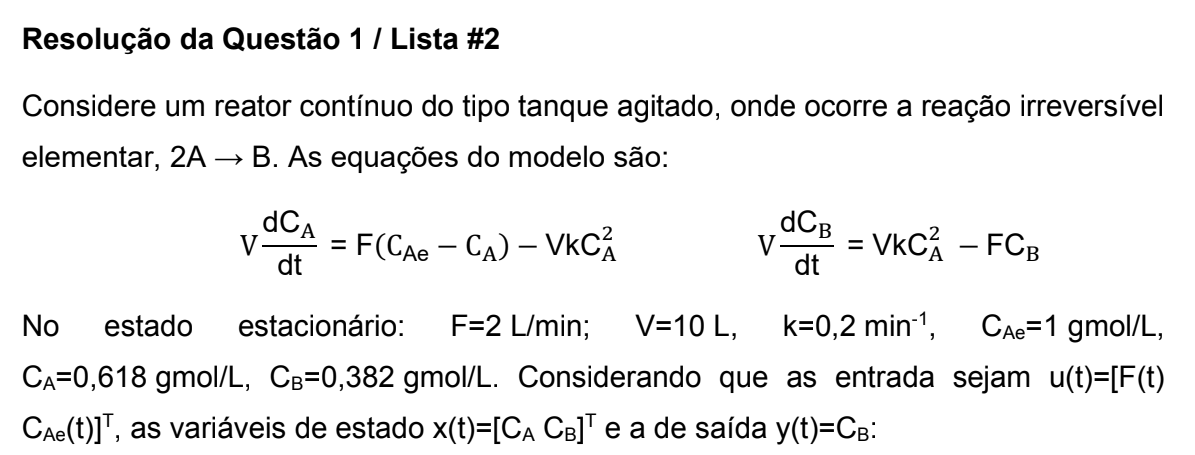

# a) Obtenha o modelo linear em torno da condição estacionária.

In [1]:
! pip install -qq control sympy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 6.8 MB/s eta 0:00:00


In [2]:
# importando as bibliotecas
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import control as ct
import sympy as sym
sym.init_printing()

# variáveis de estado
Ca, Cb = sym.symbols('C_A, C_B')

# variáveis de entrada
F, Cae = sym.symbols('F, C_{Ae}')

# parametros
V, k = sym.symbols('V, k')

# funções não lineares do sistema
f1 = (F*(Cae-Ca) - V*k*Ca**2)/V
f2 = (V*k*Ca**2 - F*Cb)/V

In [3]:
f1

     2                        
- C_A ⋅V⋅k + F⋅(-C_A + C_{Ae})
──────────────────────────────
              V               

In [4]:
f2

   2            
C_A ⋅V⋅k - C_B⋅F
────────────────
       V        

In [5]:
# Obtendo as derivadas do sistema em relação aos estados
f1_Ca, f1_Cb = sym.diff(f1,Ca), sym.diff(f1,Cb)
f2_Ca, f2_Cb = sym.diff(f2,Ca), sym.diff(f2,Cb)

# Matriz A
A = sym.Matrix([[f1_Ca, f1_Cb],
                [f2_Ca, f2_Cb]])
A

⎡-2⋅C_A⋅V⋅k - F     ⎤
⎢──────────────   0 ⎥
⎢      V            ⎥
⎢                   ⎥
⎢                -F ⎥
⎢   2⋅C_A⋅k      ───⎥
⎣                 V ⎦

In [6]:
# Obtendo as derivadas do sistema em relação às entradas
f1_F, f1_Cae = sym.diff(f1,F), sym.diff(f1,Cae)
f2_F, f2_Cae = sym.diff(f2,F), sym.diff(f2,Cae)

# Matriz B
B = sym.Matrix([[f1_F, f1_Cae],
                [f2_F, f2_Cae]])
B

⎡-C_A + C_{Ae}  F⎤
⎢─────────────  ─⎥
⎢      V        V⎥
⎢                ⎥
⎢    -C_B        ⎥
⎢    ─────      0⎥
⎣      V         ⎦

In [7]:
# Valores nominais
nominal = {'F':2.,'V': 10.,'k':0.2,
           'C_{Ae}':1.,'C_A': 0.618,'C_B':0.382}

A_num = A.subs(nominal) # calculando os valores numéricos de A
B_num = B.subs(nominal) # calculando os valores numéricos de B

In [8]:
# Representando o modelo linearizado
x = sym.Matrix([[Ca],[Cb]]) # vetor de estados
u = sym.Matrix([[F],[Cae]]) # vetor de entradas
dxdt = A_num*x + B_num*u
f1_linear = dxdt[0]
f2_linear = dxdt[1]

In [9]:
f1_linear

-0.4472⋅C_A + 0.2⋅C_{Ae} + 0.0382⋅F

In [10]:
f2_linear

0.2472⋅C_A - 0.2⋅C_B - 0.0382⋅F

# b) Expresse o modelo em espaço de estados.

In [11]:
# Espaço de estados
A = np.copy(A_num).astype(float)
B = np.copy(B_num).astype(float)
C = np.array([[0 , 1]]) # mede-se apenas Cb
D = np.zeros(2) # nenhum efeito instântaneo das entradas sobre as saídas
sys = ct.ss(A_num, B_num, C, D)
sys

<LinearIOSystem:sys[2]:['u[0]', 'u[1]']->['y[0]']>

In [12]:
# obter os polos do sistema (polos = autovalores)
p = sys.pole()
print('Os polos são:', p)

# checar a estabilidade
if any(np.real(p)>0):
    print('\n O sistema é INSTÁVEL.')
else:
    print('\n O sistema é ESTÁVEL.')

Os polos são: [-0.2   +0.j -0.4472+0.j]

 O sistema é ESTÁVEL.


# c) Obtenha a função de transferência relacionando a concentração de A na alimentação com a concentração de B na saída: $G(s) = \frac{C_B^{´}(s)}{C_{Ae}^{´}(s)}$.

In [15]:
# Funções auxiliares

def ABCD_to_tf(A,B,C,D=0):
    '''Gera uma matriz de funções de transferência simbólicas para um espaço de estados.
       Autor: Julio Dutra, em 01/set/2023'''
    s = sym.symbols('s')
    G = C*(s*sym.eye(2) - A).inv()*B #+ D
    return G.as_immutable().simplify()

def get_tf(g):
    '''Converte uma função de transferência simbólica e converte para uma
       função de transferência numérica, a qual pode ser usada para extrair
       propriedades dos sistema.
       Autor: Julio Dutra, em 01/set/2023'''
    s = sym.Symbol('s')
    num, den = g.as_numer_denom()
    num_float = [float(i) for i in sym.Poly(num).all_coeffs()] if s in num.free_symbols else  float(num)
    den_float = [float(i) for i in sym.Poly(den).all_coeffs()]
    G = ct.tf(num_float, den_float)
    return ct.minreal(G, verbose=0)


In [16]:
# Obtendo as funções de transferencia
G = ABCD_to_tf(A,B,C)
input = ['F', 'Cae']
for i in range(2):
  print(f'Cb(s)/{input[i]}(s) = {get_tf(G[i])}')

Cb(s)/F(s) = 
 -0.0382
----------
s + 0.4472

Cb(s)/Cae(s) = 
        0.04944
------------------------
s^2 + 0.6472 s + 0.08944



# d) Supondo perturbação degrau unitário em $C_{Ae}$, que tipo de resposta dinâmica pode ser observada em $C_B$? Faça o esboço deste comportamento.

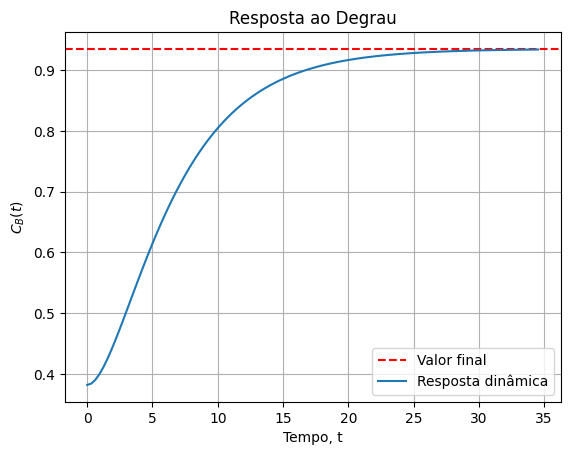

In [17]:
# selecionando o comportamento desejado
Gp = get_tf(G[0,1])

# degrau a ser aplicado
delta_u = 1.0

# Valor inicial de Cb
Cbs = 0.382

# Obtendo o valor final para um degrau unitário
y_final = delta_u*Gp.dcgain() + Cbs
plt.axhline(y_final, color='r', linestyle = '--', label = 'Valor final')

# Obtendo a resposta dinâmica
t, Cb = ct.step_response(Gp)

# Saída gráfica
plt.plot(t, delta_u*Cb + Cbs, label = 'Resposta dinâmica')
plt.grid()
plt.legend()
plt.xlabel('Tempo, t')
plt.ylabel(r'$C_B(t)$')
plt.title('Resposta ao Degrau');